In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

print(tf.__version__)

2021-11-03 03:13:41.270697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [2]:
#Check if GPU is available
tf.config.list_physical_devices('GPU')

2021-11-03 03:13:42.882451: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-03 03:13:42.884355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-03 03:13:42.956383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 03:13:42.957019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-03 03:13:42.957078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [135]:

CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]

##  Dataset Preparation

Split the dataset ....

In [128]:
AUTOTUNE = tf.data.AUTOTUNE

# prefetch the dataset
#https://www.tensorflow.org/tutorials/load_data/images
def configure_for_performance(ds,batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds



def getFMDdataset(image_dir,batch_size=8,img_size=(224,224)):
    CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="training",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory( image_dir,
                                                                class_names=CLASSES,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=0,
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                interpolation='lanczos3',
                                                                #crop_to_aspect_ratio=True,
                                                               )
    train_dataset=configure_for_performance(train_dataset,batch_size)
    val_dataset=configure_for_performance(val_dataset,batch_size)

    return train_dataset,val_dataset

In [173]:

train_dataset,val_dataset= getFMDdataset("../dataset/FMD/image",8,(224,224))

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [174]:
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

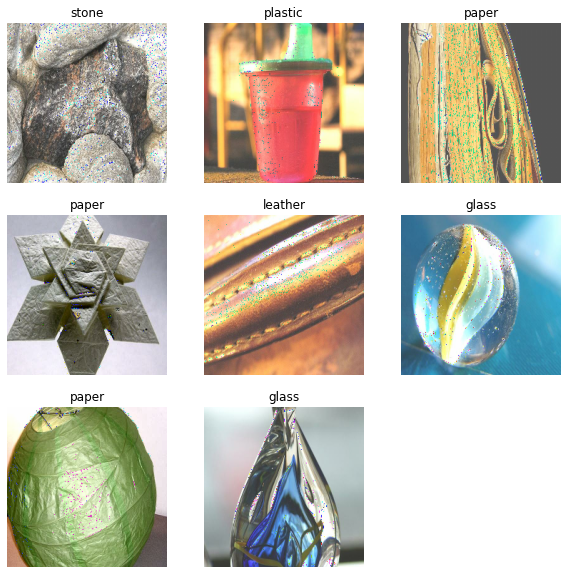

In [175]:
#visualize the dataset to ensure correctness
class_names = CLASSES
batch_size= 8
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(batch_size):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model


In [176]:
def resnet50():
    base_model=tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet')
    base_model.trainable=False
    base_model.training=False

    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(tf.keras.applications.resnet.preprocess_input, name='preprocessing', input_shape=(224, 224, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10,activation="softmax")    
    ])
    model.summary()
    return model

model=resnet50()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [177]:
LEARNING_RATE=0.001

model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [178]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE=10
early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
model_cp = ModelCheckpoint(filepath = './weights/baseline_best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [179]:
EPOCHS=30

history = model.fit(
        train_dataset,
        epochs = EPOCHS,
        validation_data=val_dataset,
        callbacks=[model_cp, early_stopper],
        use_multiprocessing=True,
        workers=4
)

Epoch 1/30
100/100 [==============================] - 4s 30ms/step - loss: 2.7198 - accuracy: 0.3095 - val_loss: 0.8016 - val_accuracy: 0.7350
Epoch 2/30
100/100 [==============================] - 2s 20ms/step - loss: 0.8717 - accuracy: 0.7253 - val_loss: 0.7767 - val_accuracy: 0.7550
Epoch 3/30
100/100 [==============================] - 2s 20ms/step - loss: 0.5980 - accuracy: 0.8126 - val_loss: 0.6145 - val_accuracy: 0.8050
Epoch 4/30
100/100 [==============================] - 2s 17ms/step - loss: 0.4278 - accuracy: 0.8501 - val_loss: 0.5727 - val_accuracy: 0.8050
Epoch 5/30
100/100 [==============================] - 2s 21ms/step - loss: 0.3020 - accuracy: 0.9013 - val_loss: 0.6434 - val_accuracy: 0.8050
Epoch 6/30
100/100 [==============================] - 2s 20ms/step - loss: 0.2912 - accuracy: 0.9020 - val_loss: 0.6389 - val_accuracy: 0.8000
Epoch 7/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2051 - accuracy: 0.9230 - val_loss: 0.7052 - val_accuracy: 0.7800

## Visualize result

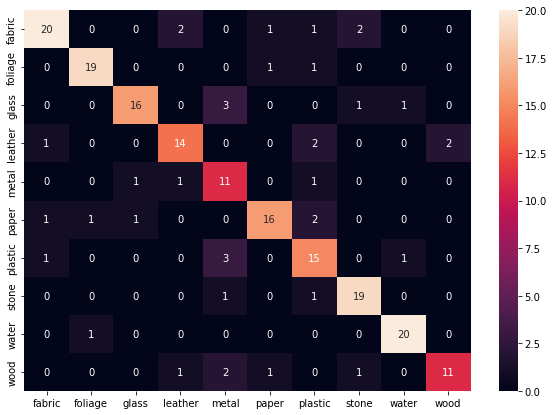

In [180]:

def plot_confusion_matrix(model,val_dataset,classes):
    predictions = np.array([])
    labels =  np.array([])
    for x, y in val_dataset:
      predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)],axis=None)
      labels = np.concatenate([labels, y],axis=None)

    confusion_matrix= tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

    df_cm = pd.DataFrame(confusion_matrix, index = classes,
                      columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
plot_confusion_matrix(model,val_dataset,CLASSES)

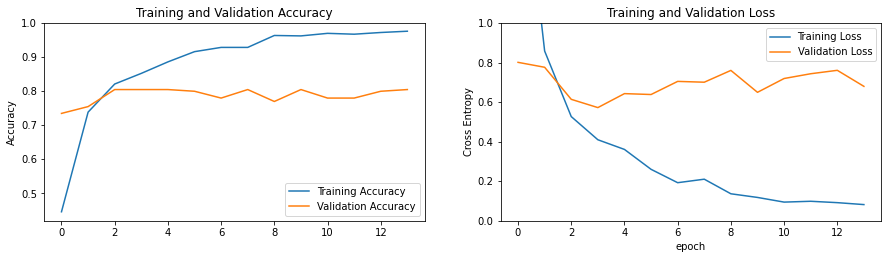

In [181]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning 

In [182]:
model.layers[1].trainable=True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers[1].layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[1].layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()


Number of layers in the base model:  175
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 10,010,634
Non-trainable params: 13,597,568
_________________________________________________________________


In [183]:
fine_tune_epochs = 10
initial_epochs=history.epoch[-1]
total_epochs = initial_epochs  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=val_dataset)

Epoch 14/23
100/100 [==============================] - 4s 27ms/step - loss: 0.4189 - accuracy: 0.8446 - val_loss: 0.9282 - val_accuracy: 0.7850
Epoch 15/23
100/100 [==============================] - 2s 23ms/step - loss: 0.0774 - accuracy: 0.9797 - val_loss: 0.7191 - val_accuracy: 0.8100
Epoch 16/23
100/100 [==============================] - 2s 22ms/step - loss: 0.0225 - accuracy: 0.9969 - val_loss: 0.7129 - val_accuracy: 0.8050
Epoch 17/23
100/100 [==============================] - 2s 25ms/step - loss: 0.0273 - accuracy: 0.9941 - val_loss: 0.7680 - val_accuracy: 0.8050
Epoch 18/23
100/100 [==============================] - 2s 25ms/step - loss: 0.0149 - accuracy: 0.9936 - val_loss: 0.7375 - val_accuracy: 0.8200
Epoch 19/23
100/100 [==============================] - 2s 25ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.7197 - val_accuracy: 0.8150
Epoch 20/23
100/100 [==============================] - 2s 24ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.6937 - val_accuracy:

In [184]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

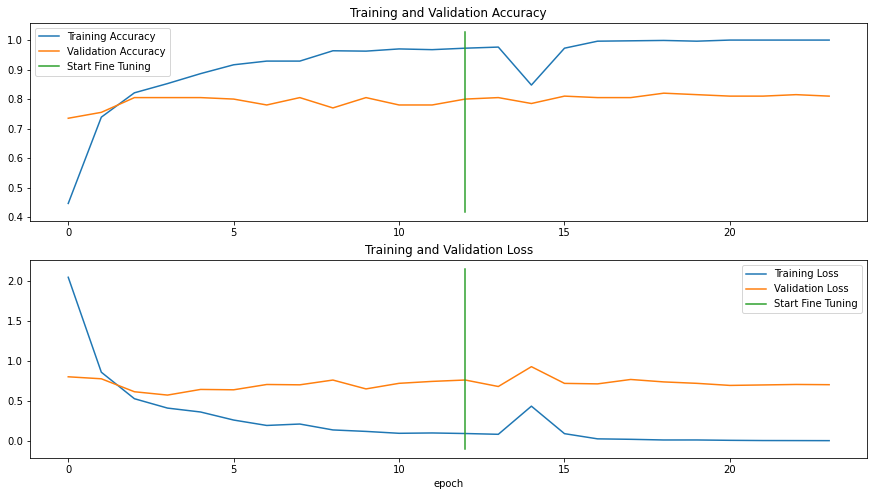

In [185]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()